In [387]:
### DEFINITIONS ###
import harp
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

FOLDER = "olfactometer_13A_2025-11-06T052526Z"
PATH = "C:/Data/Olfact/" + FOLDER  

# Containers
RegisterDict = {}

In [388]:
### ADD ANALOG DATA TO REGLIST ###
AlogReader = harp.create_reader(PATH+ "/behavior/AnalogInput.harp", include_common_registers=False)
RegisterDict['Analog'] = AlogReader.AnalogData.read()['Channel0']

In [389]:
### ADD OLFACTOMETER DATA TO REGLIST ###
OlfReader = harp.create_reader(PATH + "/behavior/Olfactometer.harp", include_common_registers=False)

# Loop through all olfactometer registers
for name, reg in OlfReader.registers.items():
    RegisterDict[name] = reg.read()

In [390]:
### FILTERING ANALOG SIGNAL AND CALCULATING DERIVATIVES ###
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

# Extract time and values
timestamp: pd.Index = RegisterDict['Analog'].index
analog_signal: np.ndarray = RegisterDict['Analog'].values

# --- STEP 1: Resample to 100 Hz ---
# Original timestamps are in seconds; create new time grid
new_rate = 100  # Hz
new_time = np.arange(timestamp[0], timestamp[-1], 1/new_rate)

# Interpolate signal to new time grid
analog_resampled = np.interp(new_time, timestamp, analog_signal)

# --- STEP 2: Apply filter (choose one option) ---
# Option 1: Median filter (best for removing spikes without overshoot)
# analog_smoothed = medfilt(analog_resampled, kernel_size=51)

# Option 2: Rolling mean (simple smoothing)
# analog_smoothed = pd.Series(analog_resampled).rolling(window=3, center=True).mean().ffill().bfill().values

# Option 3: Gaussian filter (smooth but preserves shape)
analog_smoothed = gaussian_filter1d(analog_resampled, sigma=40)

# --- STEP 3: Compute derivatives ---
analog_slope = np.gradient(analog_smoothed, new_time, edge_order=2).round()
analog_secder = np.gradient(analog_slope, new_time, edge_order=2).round()

# --- STEP 4: Store in RegisterDict ---
RegisterDict['AnalogResampled']= pd.DataFrame({'Resampled': analog_resampled}, index=new_time)
RegisterDict['AnalogSmoothed'] = pd.DataFrame({'Smoothed': analog_smoothed}, index=new_time)
RegisterDict['Analog_Slope']   = pd.DataFrame({'Slope': analog_slope}, index=new_time)
RegisterDict['Analog_SDer']    = pd.DataFrame({'SecondDerivative': analog_secder}, index=new_time)


In [391]:
### SAVING DATA TO A CSV ###

RegisterDict['AnalogResampled'].to_csv('saved/AnalogResampled.csv', index=True)
RegisterDict['AnalogSmoothed'].to_csv('saved/AnalogSmoothed.csv', index=True)
RegisterDict['Analog_Slope'].to_csv('saved/Analog_Slope.csv', index=True)
RegisterDict['Analog_SDer'].to_csv('saved/Analog_SDer.csv', index=True)

In [392]:
### ZEROING AND ROUNDING TIMESTAMP TO MS ###
start = RegisterDict['Analog'].index[0]

for reg in RegisterDict:
    RegisterDict[reg].index = (RegisterDict[reg].index - start).round(3)

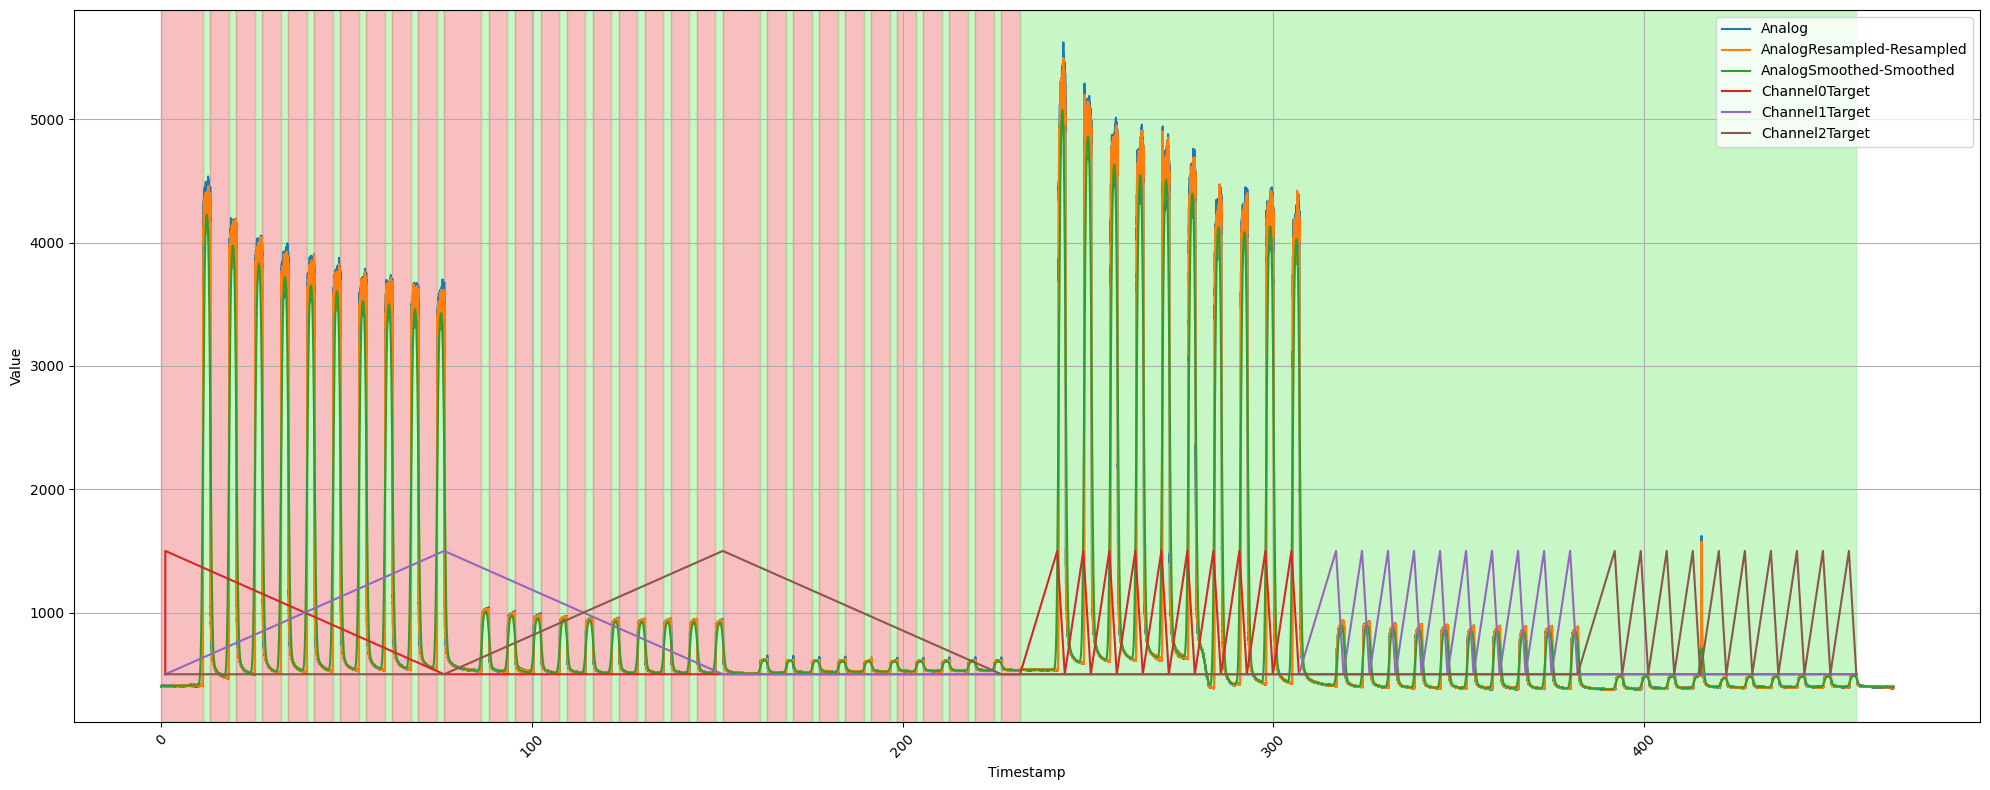

In [393]:
### GRAPH ###

endvalve_df:pd.DataFrame = RegisterDict['EndValveState']
dict_to_graph = {
    # 'Flowmeter': RegList['Flowmeter'],
    'Analog':         RegisterDict['Analog'],
    'AnalogResampled':RegisterDict['AnalogResampled'],
    'AnalogSmoothed': RegisterDict['AnalogSmoothed'], 
    'Channel0Target': RegisterDict['ChannelsTargetFlow']['Channel0']*10+500, 
    'Channel1Target': RegisterDict['ChannelsTargetFlow']['Channel1']*10+500, 
    'Channel2Target': RegisterDict['ChannelsTargetFlow']['Channel2']*10+500, 
    # 'Channel4': RegisterDict['Channel4ActualFlow']*6 
}
fig, ax = plt.subplots(figsize=(20, 8))

for name, reg in dict_to_graph.items():
    if isinstance(reg, pd.DataFrame):
        for col in reg.columns:
            plt.plot(reg.index, reg[col], label=f"{name}-{col}")
    elif isinstance(reg, pd.Series):
        plt.plot(reg.index, reg.values, label=f"{name}")

# Add background color based on endvalve state (geeen on, red off)
endvalve_state = False
start_time = RegisterDict['Analog'].index[0]
for i in range(1, len(endvalve_df)):
    if endvalve_df['EndValve0'].iloc[i] != endvalve_state:
        color = 'lightgreen' if endvalve_state else 'lightcoral'
        ax.axvspan(start_time, endvalve_df.index[i], color=color, alpha=0.5)
        endvalve_state = endvalve_df['EndValve0'].iloc[i]
        start_time = endvalve_df.index[i]
# Draw last region
color = 'lightgreen' if endvalve_state else 'lightcoral'
ax.axvspan(start_time, endvalve_df.index[-1], color=color, alpha=0.5)

# Formatting
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
ax.set_title('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


Found 63 maxima and 64 minima in 'Slope'


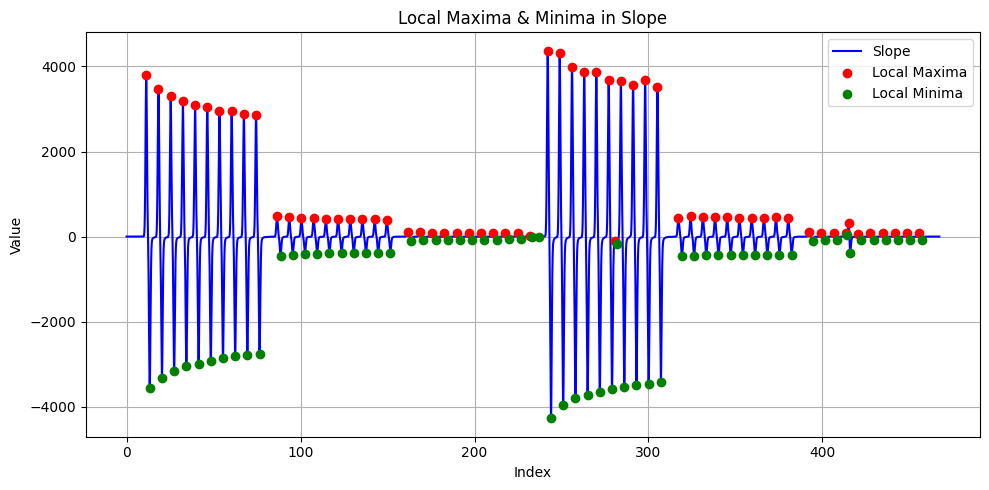

In [394]:
### FIND LOCAL MAX-MIN TO LOCATE THE START AND THE END OF THE PULSES ###
from scipy.signal import find_peaks

# Assuming df is a pandas Series or single-column DataFrame
df = RegisterDict['Analog_Slope']

# If it's a DataFrame, extract the only column
if isinstance(df, pd.DataFrame):
    signal = df.iloc[:, 0].values
    timestamp = df.index.values
    col_name = df.columns[0]
else:
    signal = df.values
    timestamp = df.index.values
    col_name = getattr(df, 'name', 'Analog')

# Parameters to tune
PROMINENCE = 10     # Minimum prominence (height difference) for a peak
DISTANCE = 100

# --- Detect maxima and minima ---
max_indices, _ = find_peaks(signal, prominence=PROMINENCE, distance=DISTANCE)
min_indices, _ = find_peaks(-signal, prominence=PROMINENCE, distance=DISTANCE)

# --- Build results DataFrame ---
pulses_df = pd.DataFrame({
    'PulseStart': False,
    'PulseEnd': False
}, index=timestamp)

pulses_df.loc[pulses_df.index[max_indices], 'PulseStart'] = True
pulses_df.loc[pulses_df.index[min_indices], 'PulseEnd'] = True

# --- Print summary ---
print(f"Found {len(max_indices)} maxima and {len(min_indices)} minima in '{col_name}'")

# --- Plot results ---
plt.figure(figsize=(10, 5))
plt.plot(timestamp, signal, label=col_name, color='blue')
plt.scatter(timestamp[max_indices], signal[max_indices], color='red', label='Local Maxima', zorder=5)
plt.scatter(timestamp[min_indices], signal[min_indices], color='green', label='Local Minima', zorder=5)

plt.title(f'Local Maxima & Minima in {col_name}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### PULSES SLICES AND GROUPING### 
from sklearn.linear_model import LinearRegression
from collections import defaultdict

df = pd.DataFrame(RegisterDict['Analog'])  # Original signal. Pulses from a baseline
# pulses_df From slope analysis, info on when the pulse starts and when it ends (approximatelly)

class Pulse:
    def __init__(self, df: pd.DataFrame, approx_start: float, approx_end: float, registers: dict, margin: float = 1.5):
        self.register_dict = registers
        self.end = approx_end + margin
        self._slice_data(df, approx_start, approx_end, margin)
        self._compute_region_metrics()
        self._get_channel_status()

    def __repr__(self):
        return (f"<Pulse start={self.pulse_start:.2f}s end={self.pulse_end:.2f}s "
                f"channel={self.active_channel} envalve={self.created_by_envalve} "
                f"squareness={self.squareness:.2f}>")

    def _slice_data(self, df, approx_start, approx_end, margin):
        self.data_start = max(approx_start - margin, df.index[0])
        self.data_end = min(approx_end + margin, df.index[-1])
        self.slice_df = df.loc[(df.index >= self.data_start) & (df.index <= self.data_end)]

        self.pulse_center = approx_start + 0.5 * (approx_end - approx_start)

        first_half = self.slice_df.loc[(self.slice_df.index >= self.data_start) & (self.slice_df.index <= self.pulse_center)]
        second_half = self.slice_df.loc[(self.slice_df.index >= self.pulse_center) & (self.slice_df.index <= self.data_end)]

        q20_1, q80_1 = np.percentile(first_half.iloc[:, 0], [20, 80])
        q20_2, q80_2 = np.percentile(second_half.iloc[:, 0], [20, 80])

        self.trigger_val_start = q20_1 + (q80_1 - q20_1) / 4
        self.trigger_val_end = q20_2 + (q80_2 - q20_2) * 3 / 4

        #Recalculating real pulse start and end
        self.pulse_start = (first_half.iloc[:, 0] >= self.trigger_val_start).idxmax()
        self.pulse_end = (second_half.iloc[:, 0] <= self.trigger_val_end).idxmax()
        self.pulse_duration = self.pulse_end - self.pulse_start

        self.plateau_region = self.slice_df.loc[(self.slice_df.index >= self.pulse_start) & (self.slice_df.index <= self.pulse_end)]
        self.pre_pulse_region = self.slice_df.loc[self.slice_df.index <= self.pulse_start]
        self.post_pulse_region = self.slice_df.loc[self.slice_df.index >= self.pulse_end]

    def _compute_region_metrics(self):
        class RegionMetrics:
            def __init__(self, df: pd.DataFrame):
                x = df.index.values
                y = df.iloc[:, 0]
                y_val = df.iloc[:, 0].values
                self.mean = y.mean()
                self.std = y.std()
                self.median, self.q20, self.q80 = np.percentile(y_val, [50, 20, 80])
                x = x.reshape(-1, 1)
                self.corrected_slope = float(LinearRegression().fit(x, y_val).coef_[0]) / (0.01*self.mean) 

                
        self.peak_value = self.slice_df.iloc[:, 0].max()
        self.peak_time = self.slice_df.iloc[:, 0].idxmax()
        
        self.plateau = RegionMetrics(self.plateau_region)
        self.pre_pulse = RegionMetrics(self.pre_pulse_region)
        self.post_pulse = RegionMetrics(self.post_pulse_region)

        pulse_auc = np.trapezoid(self.plateau_region.iloc[:, 0], self.plateau_region.index) - self.pre_pulse.q20 * self.pulse_duration
        ideal_auc = (self.plateau.q80 - self.pre_pulse.q20) * self.pulse_duration
        self.pulse_squareness = pulse_auc / ideal_auc if ideal_auc else 0

        duration_prepulse = self.pulse_start - self.data_start
        duration_postpulse = self.data_end - self.pulse_end

        before_auc = max(np.trapezoid(self.pre_pulse_region.iloc[:, 0], self.pre_pulse_region.index) - self.pre_pulse.q20 * duration_prepulse, 0)
        after_auc = max(np.trapezoid(self.post_pulse_region.iloc[:, 0], self.post_pulse_region.index) - self.post_pulse.q20 * duration_postpulse, 0)

        before_empty = duration_prepulse * (self.plateau.mean - self.pre_pulse.mean)
        after_empty = duration_postpulse * (self.plateau.mean - self.post_pulse.q20)
        baselines_aoc = before_empty - before_auc + after_empty - after_auc
        self.baselines_squareness = baselines_aoc / (before_empty + after_empty) if (before_empty + after_empty) else 0

        self.squareness = self.pulse_squareness * self.baselines_squareness

    def _get_channel_status(self):
        def get_open_status(df:pd.DataFrame, query_time:float, columns:list[str] = None):
            """
            Given a DataFrame with time-indexed or time-column data, returns which channel/valve is 
            active (non-zero or True), its value, and how long it has been active.
            
            Parameters
            ----------
            df : pd.DataFrame
                Must contain a time column ('Time') or a time index.
            query_time : float
                Time at which to check status.
            columns : list of str, optional
                Columns to check (default: all columns except 'Time')
            
            Returns
            -------
            list
                ['channel', 'value', 'open_time', 'elapsed_time']
            """
            # If 'Time' is an index, convert it into a column for easier access
            if 'Time' not in df.columns:
                df = df.reset_index()

            df = df.sort_values('Time').reset_index(drop=True)

            # Default columns = all except 'Time'
            if columns is None:
                columns = [c for c in df.columns if c != 'Time']

            # Find the most recent row before or at the given time
            valid_rows = df[df['Time'] <= query_time]
            if valid_rows.empty:
                return [None, None, -1, -1]
            current_row = valid_rows.iloc[-1]

            # Determine active (True or nonzero) columns
            active_cols = []
            for c in columns:
                val = current_row[c]
                if isinstance(val, (bool, np.bool_)):
                    if val:
                        active_cols.append(c)
                elif isinstance(val, (int, float)) and val != 0:
                    active_cols.append(c)

            if len(active_cols)>1:
                print(f"Warning! At {query_time}s there is more than one channel open: {active_cols}")

            if active_cols:
                # Find when it last became active
                col = active_cols[0]
                val = current_row[col]
                current_time = current_row['Time']

                # Slice the dataframe up to and including current_time
                df_slice = df[df['Time'] <= current_time]

                # Reverse iterate to find when it changed from inactive to active
                open_time = df_slice.iloc[-1]['Time']  # default to current_time
                for i in range(len(df_slice) - 2, -1, -1):
                    prev_val = df_slice.iloc[i][col]
                    if isinstance(prev_val, (bool, np.bool_)) and not prev_val:
                        open_time = df_slice.iloc[i + 1]['Time']
                        break
                    elif isinstance(prev_val, (int, float)) and prev_val == 0:
                        open_time = df_slice.iloc[i + 1]['Time']
                        break
                    elif i == 0:
                        open_time = df_slice.iloc[0]['Time']
                
                val = int(current_row[col])
                elapsed = float(round(query_time - open_time,3))
            else:
                return [None, None, -1, -1]
            
            return [col, val, open_time, elapsed]

        status = get_open_status(self.register_dict['ChannelsTargetFlow'], self.pulse_start, columns=['Channel0', 'Channel1', 'Channel2'])
        endvalve = get_open_status(self.register_dict['EndValveState'], self.pulse_start)

        self.active_channel = status[0]
        self.t_active_channel = status[2]
        self.dt_active_channel = status[3]

        self.endvalve_state = endvalve[1]
        self.t_active_endvalve = endvalve[2]
        self.dt_active_endvalve = endvalve[3]

        self.created_by_envalve = self.dt_active_endvalve < self.dt_active_channel if self.active_channel else False


    def is_valid(self):
        return (
            self.plateau.mean > self.pre_pulse.mean * 1.05 and
            self.plateau.mean > self.post_pulse.mean * 1.05 and
            self.endvalve_state and
            self.active_channel is not None
        )
    
    def plot(self, ax=None, color='blue', label=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 3))

        slice_df = self.slice_df
        y = slice_df.iloc[:, 0] - self.pre_pulse.mean
        aligned_time = slice_df.index.to_numpy() - self.pulse_start

        trigger_time = (self.t_active_endvalve if self.created_by_envalve else self.t_active_channel) - self.pulse_start
        ax.axvline(trigger_time, color=color, linestyle='--')

        label = label or f"Sq={self.squareness:.2f}, Delay={trigger_time*1000:.0f}ms"
        ax.plot(aligned_time, y, label=label, color=color)
        ax.axvline(self.pulse_start - self.pulse_start, color='0', linestyle=':', label='PulseStart')
        ax.axvline(self.pulse_end- self.pulse_start, color='0', linestyle=':', label='PulseEnd')
        ax.axhline(self.plateau.q80 - self.pre_pulse.mean, color='0.4', linestyle=':', label='Plateau')
        ax.axhline(self.pre_pulse.q20 - self.pre_pulse.mean, color='0.2', linestyle=':', label='Baseline-left')
        ax.axhline(self.post_pulse.q20 - self.pre_pulse.mean, color='0.6', linestyle=':', label='Baseline-right')        
        ax.set_title(f"Pulse | Channel: {self.active_channel} | Envalve: {self.created_by_envalve}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Signal (baseline corrected)")
        ax.grid(True, linestyle=':', alpha=0.5)
        ax.legend()

    def to_dict(self):
        return self.__dict__

class PulseGroup:
    def __init__(self, pulses: list, 
                 channel:str, 
                 pulses_created_by_envalve: bool, 
                 metrics_list: list[str] = [
                    'plateau.median', 
                    'plateau.q80',
                    'plateau.q20',
                    
                    'pre_pulse.q20',
                    'post_pulse.q20',
                    'pre_pulse.mean',
                    'post_pulse.mean',

                    'pre_pulse.corrected_slope',
                    'pre_pulse.corrected_slope',
                    'post_pulse.corrected_slope',

                    'dt_active_endvalve',
                    'dt_active_channel']
                ):
        
        self.pulses = pulses
        self.channel = channel
        self.pulses_created_by_envalve = pulses_created_by_envalve
        self.metrics = self.aggregate_metrics(metrics_list)

    def __iter__(self):
        return iter(self.pulses)

    def __len__(self):
        return len(self.pulses)

    def __repr__(self):
        return f"<PulseGroup total_pulses={len(self.pulses)} Channel={(self.channel)}. Created by endvalve {self.pulses_created_by_envalve}>"

    def aggregate_metrics(self, metrics_list: list[str]):
        """
        Computes mean and std of a nested attribute across all pulses in each group.
        Returns a dictionary keyed by group with metric summaries.
        """
        def get_nested_attr(obj, path):
            for part in path.split('.'):
                obj = getattr(obj, part)
            return obj

        # Collect data: {metric: {mean, std, count}}}}
        metrics_by_group = {}
        for metric in metrics_list:
            values = []
            for pulse in self.pulses:
                try:
                    val = get_nested_attr(pulse, metric)
                    values.append(val)
                except AttributeError:
                    print(f"Attribute {metric} not found in pulse")
                    continue

            if values:
                values = np.array(values)
                metrics_by_group[metric] = {
                    'mean': float(np.mean(values)),
                    'std': round(float(np.std(values)),2),
                    'count': len(values)
                }
            else:
                metrics_by_group[metric] = {
                    'mean': None,
                    'std': None,
                    'count': 0
                }
        return metrics_by_group

# Create pulses
pulses = []

for pulse_start in pulses_df.index[pulses_df['PulseStart']]:
    next_pulse_end = pulses_df.index[(pulses_df.index > pulse_start) & pulses_df['PulseEnd']]
    if len(next_pulse_end) == 0:
        continue
    pulse_end = next_pulse_end[0]

    pulse = Pulse(df, pulse_start, pulse_end, RegisterDict)
    if pulse.is_valid():
        pulses.append(pulse)
        # pulse.plot()
    else:
        print(f"Pulse in t={pulse.pulse_center} not valid")
        # pulse.plot()

# Group pulses by (channel, envalve)
grouped = defaultdict(list)
for pulse in pulses:
    grouped[(pulse.active_channel, pulse.created_by_envalve)].append(pulse)

# Create PulseGroup instances and assign index to each pulse
groups = {}
for (channel, pulses_created_by_envalve), pulses_in_group in grouped.items():
    key = str(channel) + "-Endvalve:" + str(pulses_created_by_envalve)
    for idx, pulse in enumerate(pulses_in_group):
        pulse.idx = idx
    groups[key]=PulseGroup(pulses_in_group, channel, pulses_created_by_envalve)

Pulse in t=232.415 not valid
Pulse in t=281.15 not valid
Pulse in t=413.78 not valid


In [ ]:
#test
print(groups.keys())
group = groups['Channel0-Endvalve:True']
print(group)
print(group.metrics["plateau.median"])

dict_keys(['Channel0-Endvalve:True', 'Channel1-Endvalve:True', 'Channel2-Endvalve:True', 'Channel0-Endvalve:False', 'Channel1-Endvalve:False', 'Channel2-Endvalve:False'])
<PulseGroup total_pulses=10 Channel=Channel0. Created by endvalve True>
{'mean': 3716.0, 'std': 240.86, 'count': 10}


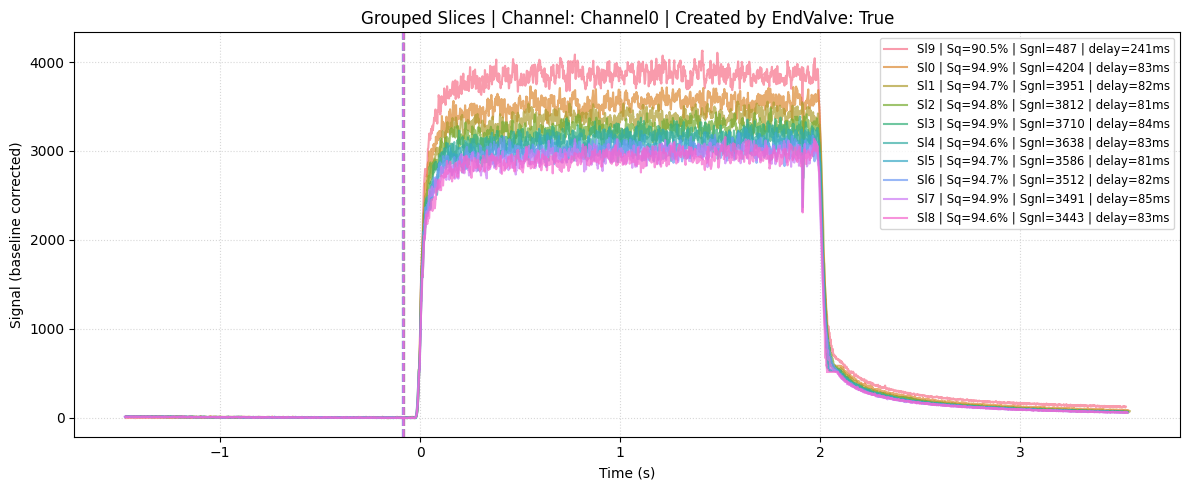

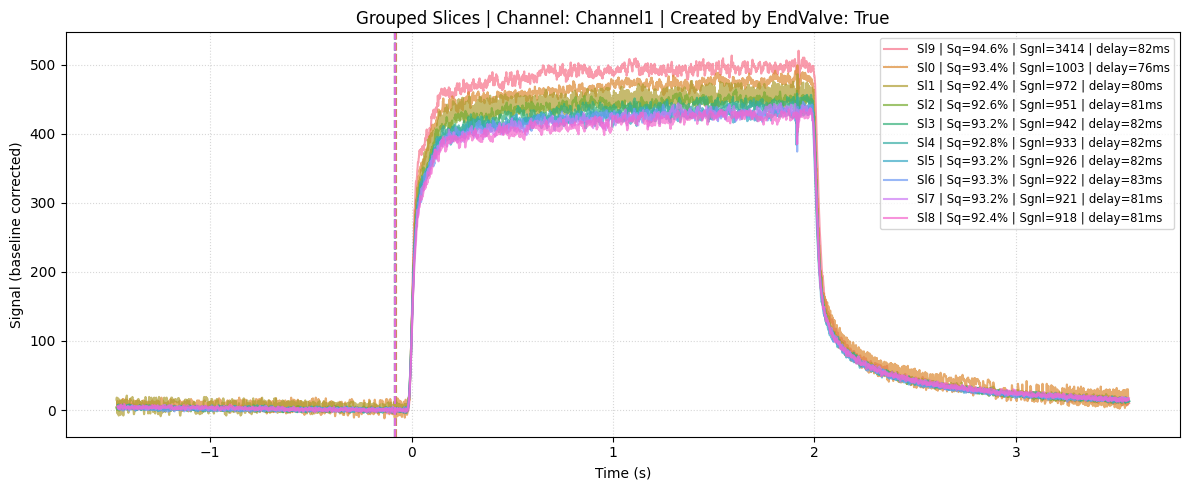

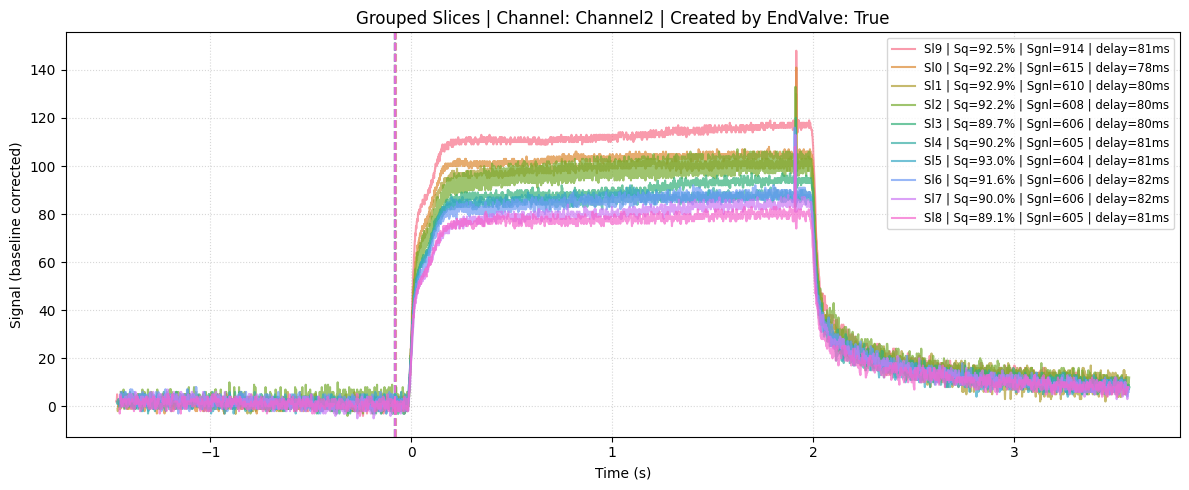

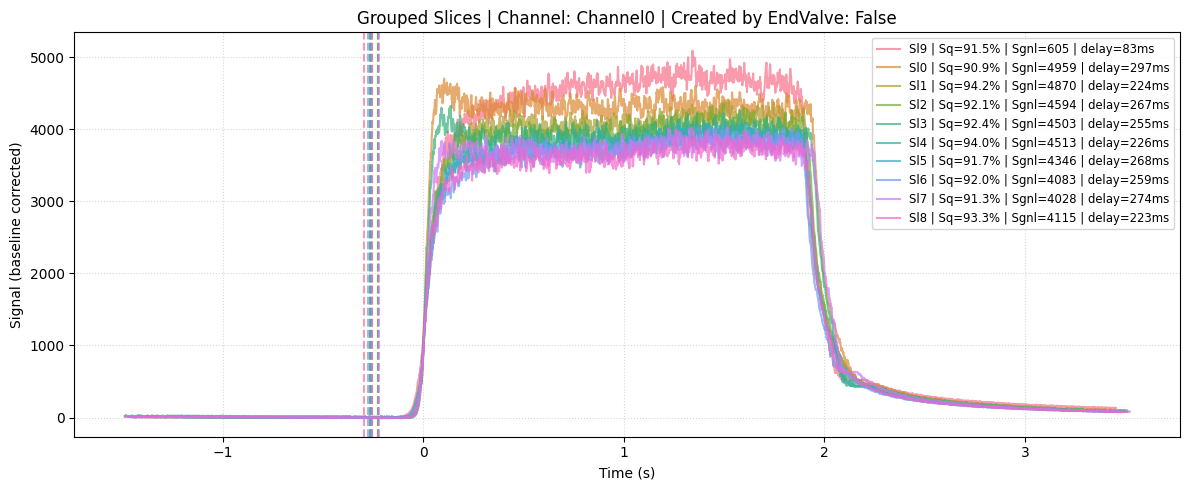

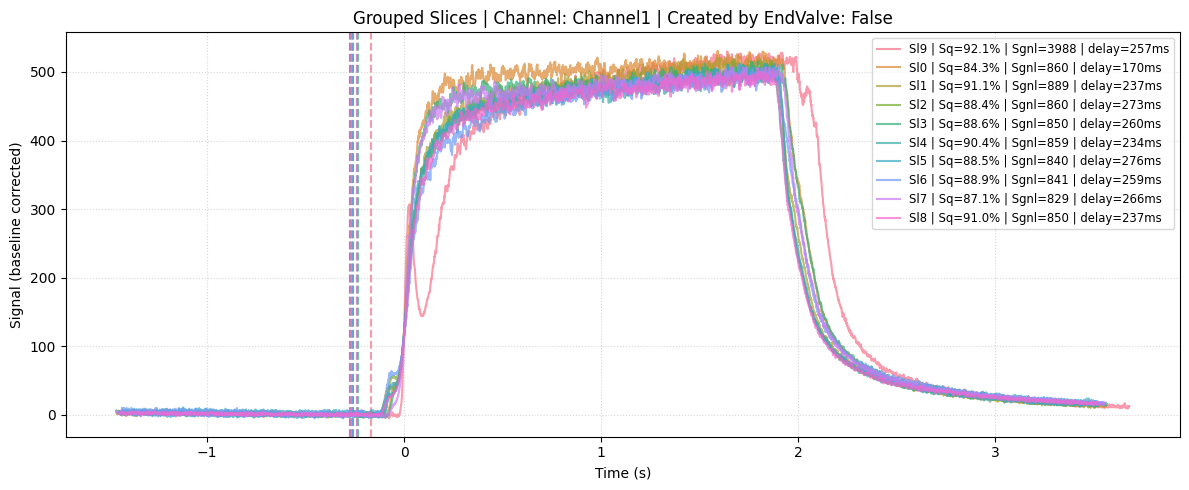

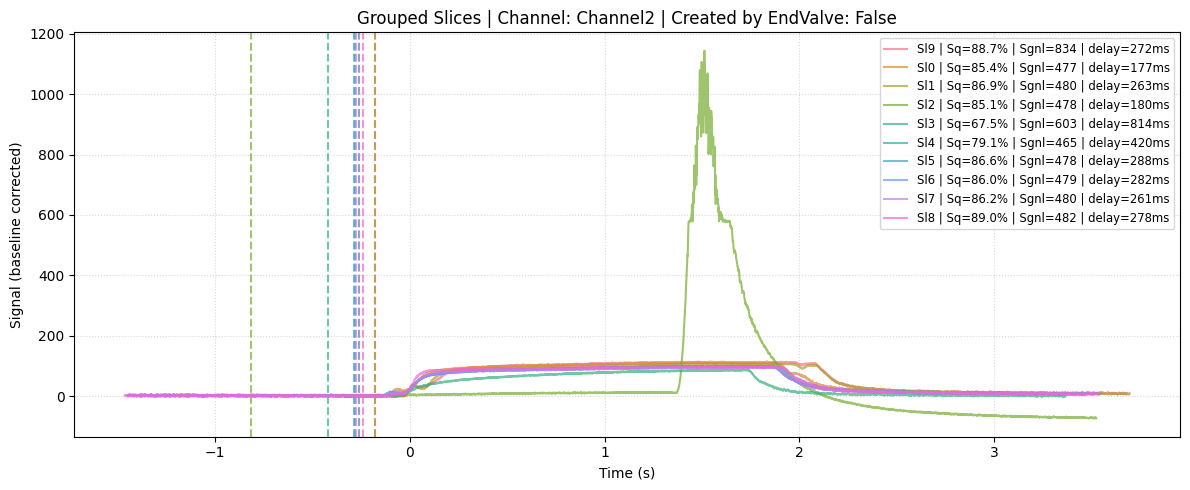

In [ ]:
### Plot each slice group in a shared graph ###
for pulse_group in groups.values():
    plt.figure(figsize=(12, 5))
    colors = sns.color_palette("husl", len(pulse_group))
    colors = [(r, g, b, 0.7) for r, g, b in colors]

    for j, pulse in enumerate(pulse_group):
        y = pulse.slice_df.iloc[:, 0] - pulse.pre_pulse.q20
        aligned_time = pulse.slice_df.index.to_numpy() - pulse.pulse_start
        plt.plot(aligned_time, y, label=label, color=colors[j])

        if pulse.created_by_envalve:
            trigger_time = pulse.t_active_endvalve - pulse.pulse_start
            label = (
                f"Sl{pulse.idx} | Sq={pulse.squareness*100:.1f}% | "
                f"Sgnl={pulse.plateau.mean:.0f} | "
                f"delay={pulse.dt_active_endvalve*1000:.0f}ms"
            )
        else:
            trigger_time = pulse.t_active_channel - pulse.pulse_start
            label = (
                f"Sl{pulse.idx} | Sq={pulse.squareness*100:.1f}% | "
                f"Sgnl={pulse.plateau.mean:.0f} | "
                f"delay={pulse.dt_active_channel*1000:.0f}ms"
            )
        plt.axvline(trigger_time, color=colors[j], linestyle='--')
        
    plt.title(f"Grouped Slices | Channel: {pulse_group.channel} | Created by EndValve: {pulse_group.pulses_created_by_envalve}")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal (baseline corrected)")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_combined_group_dashboard(groups, metric_paths):
    metrics = metric_paths
    channels = sorted({ch for metric in data.values() for ch in metric.keys()})
    plt.figure(figsize=(8, 4))
    
    # x = np.arange(len(metrics))
    # width = 0.8 / len(channels)
    # for i, channel in enumerate(channels):
    #     means = [data.get(metric, {}).get(channel, {}).get('mean', np.nan) for metric in metrics]
    #     stds = [data.get(metric, {}).get(channel, {}).get('std', 0) for metric in metrics]
    #     plt.bar(x + i * width, means, width=width, yerr=stds, capsize=4, label=channel)
    # plt.xticks(x + width * (len(channels) - 1) / 2, metrics, rotation=45, ha='right')


    x = np.arange(len(channels))
    width = 0.8 / len(metrics)
    for i, metric in enumerate(metrics):
        means = [ group.metrics[metric_paths]['mean'] ]
        stds = [ group.metrics[metric_paths]['std']]
        plt.bar(x + i * width, means, width=width, yerr=stds, capsize=4, label=metric)
    plt.xticks(x + width * (len(metrics) - 1) / 2, channels, rotation=45, ha='right')
    plt.legend()
    plt.ylabel("Value")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.show()    


metrics_squareness = ['squareness',]
metrics_plateau = [
    ashbo

AttributeError: 'str' object has no attribute 'channel'